In [134]:
# Cell 1: Import Libraries dan Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
import joblib
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
try:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
except:
    pass

print("✅ Libraries berhasil diimport!")

✅ Libraries berhasil diimport!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [135]:
# Cell 2: Definisi Kata Kunci Negatif dan Positif
# Daftar kata negatif/badword dalam bahasa Indonesia
BADWORDS_INDONESIAN = [
    'anjing', 'babi', 'bangsat', 'brengsek', 'bodoh', 'tolol', 'goblok', 'idiot',
    'sialan', 'keparat', 'bajingan', 'kampret', 'monyet', 'tai', 'shit', 'fuck',
    'damn', 'hell', 'stupid', 'moron', 'asshole', 'bastard', 'bitch', 'sucks',
    'hate', 'worst', 'terrible', 'awful', 'disgusting', 'pathetic', 'useless',
    'garbage', 'trash', 'worthless', 'loser', 'failure', 'disappointing',
    'buruk', 'jelek', 'menjijikkan', 'menyebalkan', 'kesal', 'marah', 'benci',
    'sampah', 'busuk', 'rusak', 'hancur', 'payah', 'lemah', 'gagal', 'zonk',
    'kecewa', 'sedih', 'menyedihkan', 'mengerikan', 'ngeri', 'serem', 'takut'
]

# Kata-kata positif untuk counterbalance
POSITIVE_WORDS = [
    'bagus', 'baik', 'hebat', 'keren', 'mantap', 'awesome', 'amazing', 'great',
    'excellent', 'wonderful', 'fantastic', 'perfect', 'love', 'like', 'good',
    'best', 'beautiful', 'nice', 'cool', 'sweet', 'brilliant', 'outstanding',
    'superb', 'magnificent', 'extraordinary', 'impressive', 'remarkable',
    'senang', 'gembira', 'suka', 'cinta', 'indah', 'cantik', 'menawan',
    'luar biasa', 'istimewa', 'terbaik', 'sempurna', 'memuaskan', 'puas'
]

print(f"✅ Kata negatif: {len(BADWORDS_INDONESIAN)} kata")
print(f"✅ Kata positif: {len(POSITIVE_WORDS)} kata")

✅ Kata negatif: 59 kata
✅ Kata positif: 40 kata


In [136]:
def clean_text(text):
    """Fungsi untuk membersihkan teks"""
    if pd.isna(text) or text is None:
        return ""

    text = str(text).lower()
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Hapus mention dan hashtag
    text = re.sub(r'@\w+|#\w+', '', text)
    # Hapus karakter khusus dan angka, tapi pertahankan spasi
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Test fungsi clean_text
test_text = "Anjing!!! Video ini @username #hashtag http://test.com 12345 jelek banget!!!"
cleaned = clean_text(test_text)
print("Original:", test_text)
print("Cleaned:", cleaned)

Original: Anjing!!! Video ini @username #hashtag http://test.com 12345 jelek banget!!!
Cleaned: anjing video ini jelek banget


In [137]:
def calculate_sentiment_score(text):
    """Menghitung skor sentimen berdasarkan kata kunci"""
    if not text or pd.isna(text):
        return 0

    text = str(text).lower()
    words = text.split()

    negative_count = sum(1 for word in words if word in BADWORDS_INDONESIAN)
    positive_count = sum(1 for word in words if word in POSITIVE_WORDS)

    # Hitung skor dengan bobot
    score = positive_count - (negative_count * 2)  # Kata negatif diberi bobot lebih besar

    return score

def create_sentiment_label_improved(text):
    """Menentukan label sentimen yang lebih akurat"""
    if pd.isna(text) or not text:
        return 1  # Netral untuk teks kosong

    text = str(text)
    clean_text_content = clean_text(text)

    # Hitung skor berdasarkan kata kunci
    sentiment_score = calculate_sentiment_score(clean_text_content)

    # Faktor panjang teks
    length = len(clean_text_content)

    # Logika penentuan sentimen
    if sentiment_score < -1:  # Ada kata negatif yang dominan
        return 0  # Negatif
    elif sentiment_score > 1:  # Ada kata positif yang dominan
        return 2  # Positif
    else:
        # Jika tidak ada kata kunci yang jelas, gunakan panjang teks
        if length < 10:
            return 0  # Teks sangat pendek cenderung negatif
        elif length < 30:
            return 1  # Netral
        else:
            return 2  # Teks panjang cenderung positif

# Test fungsi sentimen
test_comments = [
    "Anjing video apaan ini!",
    "Bagus banget videonya!",
    "Biasa aja",
    "ok"
]

for comment in test_comments:
    score = calculate_sentiment_score(comment)
    label = create_sentiment_label_improved(comment)
    labels = {0: "Negatif", 1: "Netral", 2: "Positif"}
    print(f"'{comment}' -> Score: {score}, Label: {labels[label]}")

'Anjing video apaan ini!' -> Score: -2, Label: Negatif
'Bagus banget videonya!' -> Score: 1, Label: Netral
'Biasa aja' -> Score: 0, Label: Negatif
'ok' -> Score: 0, Label: Negatif


In [138]:
# Cell 5: Load dan Preprocessing Dataset
# Load dataset
try:
    df = pd.read_csv('cleaned_youtube_commentss.csv')
    print("✅ Dataset berhasil dimuat!")
    print(f"Jumlah data: {len(df)}")
    print("Kolom yang tersedia:", df.columns.tolist())

    # Lihat sample data
    print("\n5 baris pertama:")
    print(df.head())

except FileNotFoundError:
    print("⚠️ File 'cleaned_youtube_commentss.csv' tidak ditemukan!")
    print("Membuat dataset contoh...")

    # Buat dataset contoh untuk testing
    sample_comments = [
        "Video ini bagus banget, suka deh!",
        "Kontennya jelek, boring sekali",
        "Biasa aja sih videonya",
        "Mantap keren abis videonya",
        "Anjing video apaan ini, sampah!",
        "Wah hebat sekali penjelasannya",
        "Goblok banget sih pembawa acaranya",
        "Video yang sangat bermanfaat dan informatif",
        "Mengecewakan sekali hasilnya",
        "Perfect! Exactly what I needed",
        "Tolol banget konten kayak gini",
        "Amazing content, love it!",
        "Meh, nothing special",
        "Brilliant explanation, thanks!",
        "Stupid waste of time",
        "Luar biasa bagus videonya",
        "Payah banget editingnya",
        "So beautiful and inspiring",
        "Terrible quality, disappointed",
        "Keren maksimal!"
    ]

    df = pd.DataFrame({
        'Clean_Comment': sample_comments
    })

    print("✅ Dataset contoh berhasil dibuat!")

# Preprocessing
df['Clean_Comment'] = df['Clean_Comment'].apply(clean_text)
df['Sentiment'] = df['Clean_Comment'].apply(create_sentiment_label_improved)

print(f"\n✅ Preprocessing selesai!")
print(f"Total data: {len(df)}")
print(f"Data kosong: {df['Clean_Comment'].isna().sum()}")

✅ Dataset berhasil dimuat!
Jumlah data: 5582
Kolom yang tersedia: ['VideoID', 'Username', 'Comment', 'Timestamp', 'Date', 'Clean_Comment']

5 baris pertama:
       VideoID              Username  \
0  _5AKKX1MYR8      @wjsofficial4877   
1  _5AKKX1MYR8      @arisgunawan9608   
2  _5AKKX1MYR8  @muh.fathanmulya8296   
3  _5AKKX1MYR8         @RomansyahTia   
4  _5AKKX1MYR8       @FiraRamadhania   

                                             Comment             Timestamp  \
0               Beli di online suaranya bisa gak ya😂  2025-06-09T10:00:37Z   
1                                        I like this  2025-06-09T07:50:12Z   
2  Sehat2 semua orang tua didunia ini Termasuk or...  2025-06-07T12:32:03Z   
3                                  Semangat ya ariel  2025-06-07T06:21:12Z   
4                   Lagu ayah don terharu bangett ya  2025-06-06T11:21:30Z   

                   Date                                      Clean_Comment  
0  2025-06-09T10:00:37Z                beli di online su

Distribusi sentimen:
Sentiment
0     385
1    1173
2    4024
Name: count, dtype: int64


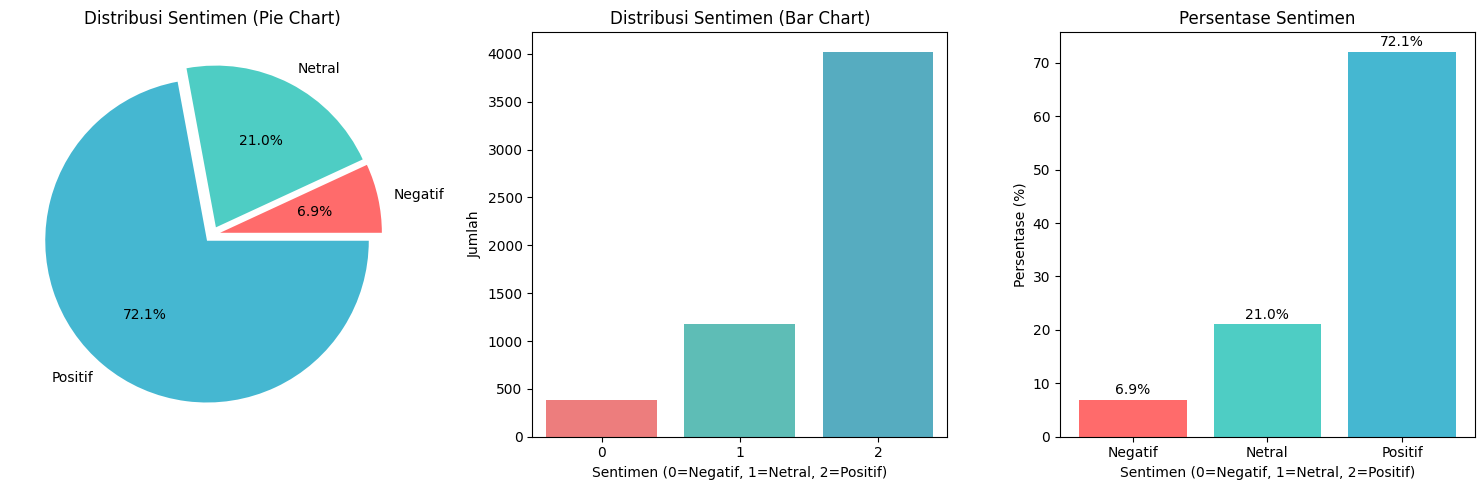

In [139]:
# Cell 6: Analisis Distribusi Sentimen
print("Distribusi sentimen:")
sentiment_dist = df['Sentiment'].value_counts().sort_index()
print(sentiment_dist)

# Visualisasi distribusi sentimen
plt.figure(figsize=(15, 5))

# Pie chart
plt.subplot(1, 3, 1)
labels = ['Negatif', 'Netral', 'Positif']
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
plt.pie(sentiment_dist.values, labels=[labels[i] for i in sentiment_dist.index],
        autopct='%1.1f%%', colors=[colors[i] for i in sentiment_dist.index],
        explode=(0.05, 0.05, 0.05))
plt.title('Distribusi Sentimen (Pie Chart)')

# Bar chart
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='Sentiment', palette=['#ff6b6b', '#4ecdc4', '#45b7d1'])
plt.title('Distribusi Sentimen (Bar Chart)')
plt.xlabel('Sentimen (0=Negatif, 1=Netral, 2=Positif)')
plt.ylabel('Jumlah')

# Persentase dalam bar chart
plt.subplot(1, 3, 3)
percentages = df['Sentiment'].value_counts(normalize=True).sort_index() * 100
bars = plt.bar(range(len(percentages)), percentages.values,
               color=[colors[i] for i in percentages.index])
plt.title('Persentase Sentimen')
plt.xlabel('Sentimen (0=Negatif, 1=Netral, 2=Positif)')
plt.ylabel('Persentase (%)')
plt.xticks(range(len(percentages)), [labels[i] for i in percentages.index])

# Tambahkan nilai di atas bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

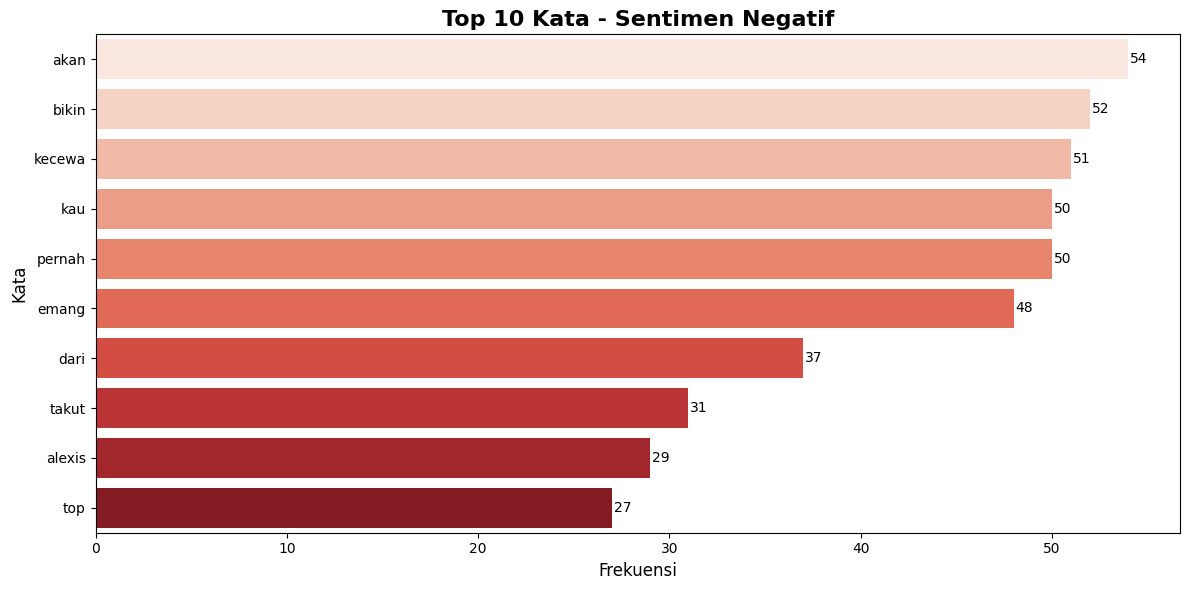

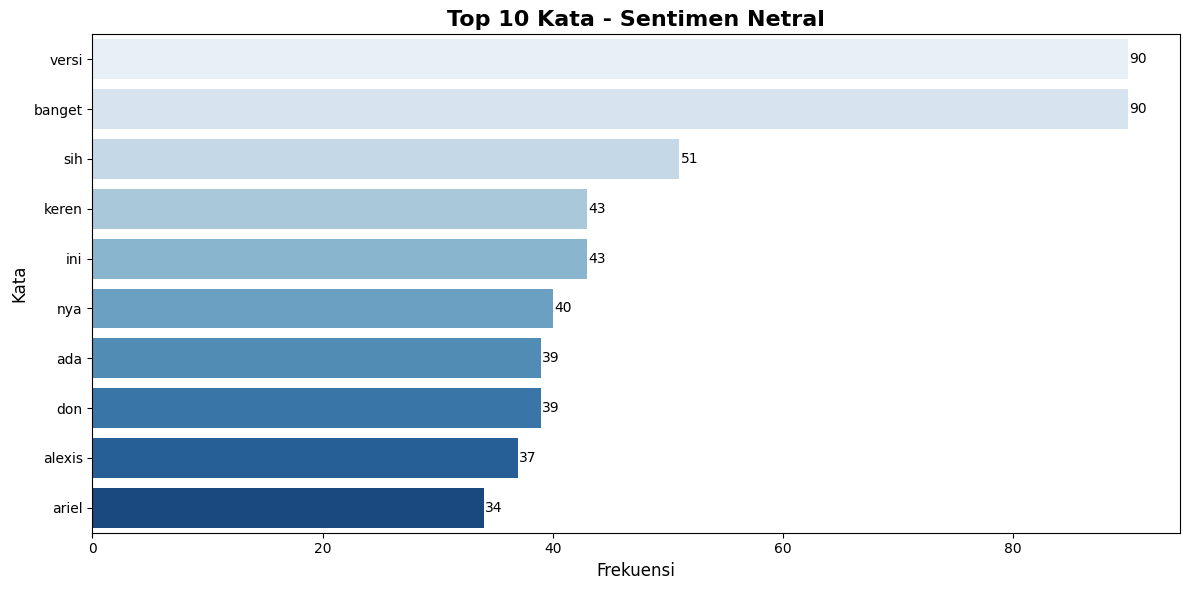

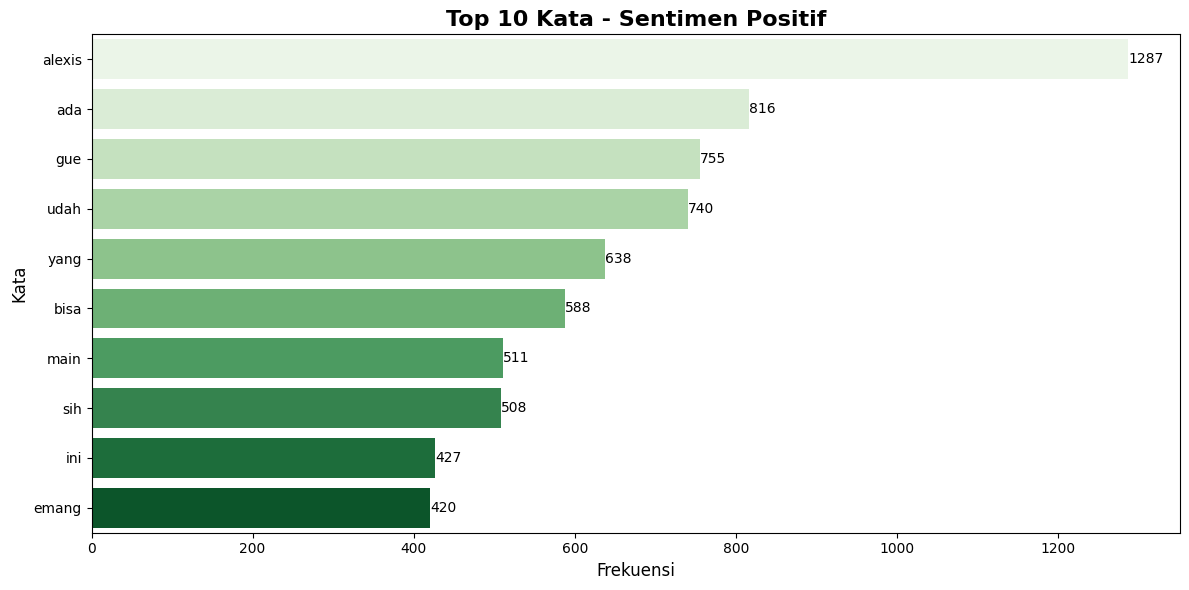

In [140]:
# Cell 7: Analisis Kata Kunci per Sentimen
def analyze_keywords_by_sentiment():
    """Analisis kata kunci untuk setiap sentimen"""
    sentiment_labels = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

    for sentiment_val, sentiment_name in sentiment_labels.items():
        if sentiment_val in df['Sentiment'].values:
            texts = df[df['Sentiment'] == sentiment_val]['Clean_Comment'].fillna('').astype(str)

            if len(texts) > 0 and any(text.strip() for text in texts):
                words = ' '.join(texts).split()
                words = [word for word in words if word.strip() != '' and len(word) > 2]

                if words:
                    top_words = Counter(words).most_common(10)

                    plt.figure(figsize=(12, 6))
                    if top_words:
                        words_list = [word for word, count in top_words]
                        counts_list = [count for word, count in top_words]

                        colors_map = {'Negatif': 'Reds', 'Netral': 'Blues', 'Positif': 'Greens'}
                        sns.barplot(x=counts_list, y=words_list, palette=colors_map[sentiment_name])
                        plt.title(f'Top 10 Kata - Sentimen {sentiment_name}', fontsize=16, fontweight='bold')
                        plt.xlabel('Frekuensi', fontsize=12)
                        plt.ylabel('Kata', fontsize=12)

                        # Tambahkan nilai di ujung bar
                        for i, (word, count) in enumerate(top_words):
                            plt.text(count + 0.1, i, str(count), va='center')

                        plt.tight_layout()
                        plt.show()
                    else:
                        print(f"Tidak ada kata yang cukup untuk sentimen {sentiment_name}")
            else:
                print(f"Tidak ada data untuk sentimen {sentiment_name}")

analyze_keywords_by_sentiment()


🎨 Generating Word Cloud untuk Negatif...


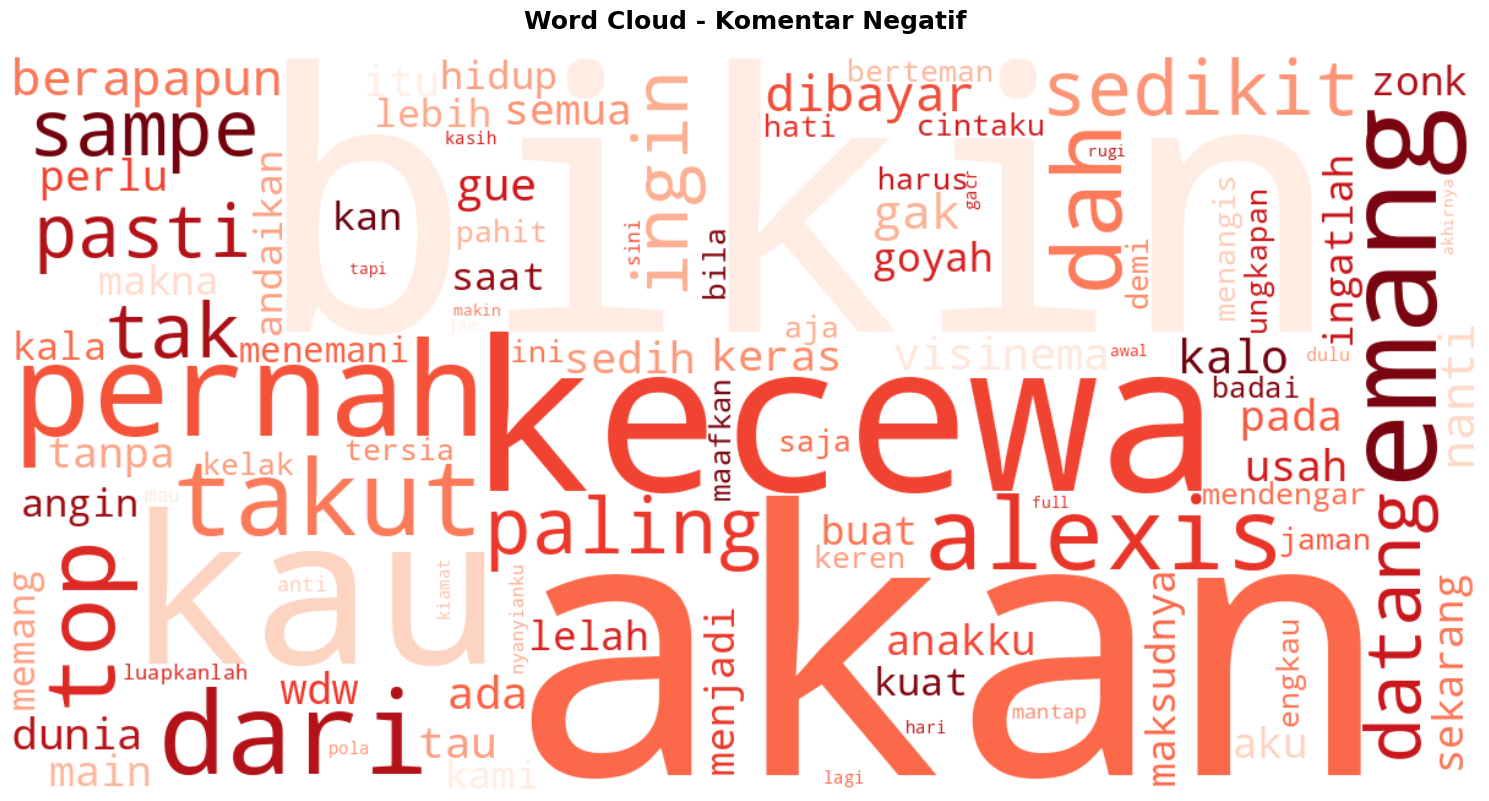


🎨 Generating Word Cloud untuk Netral...


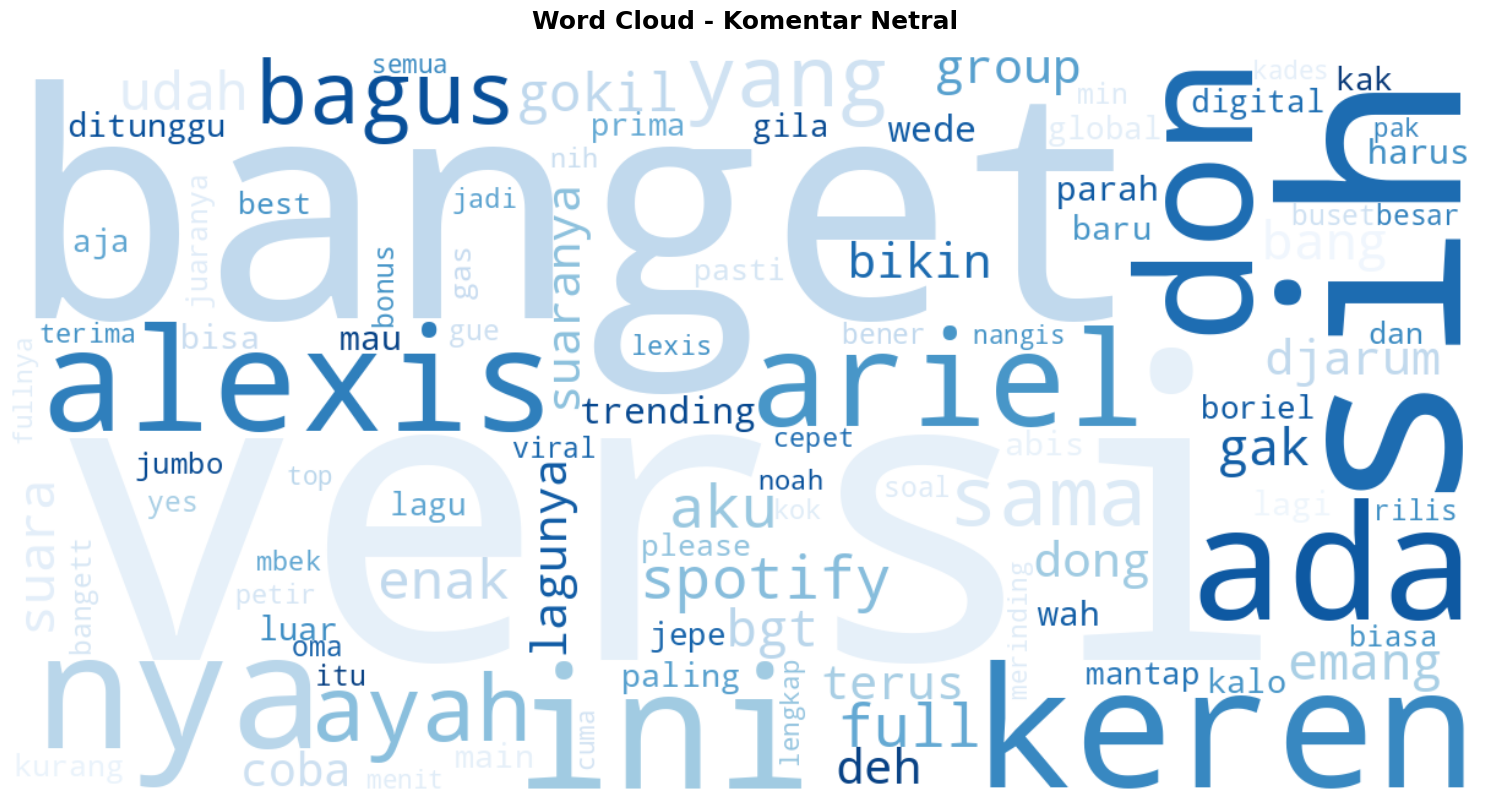


🎨 Generating Word Cloud untuk Positif...


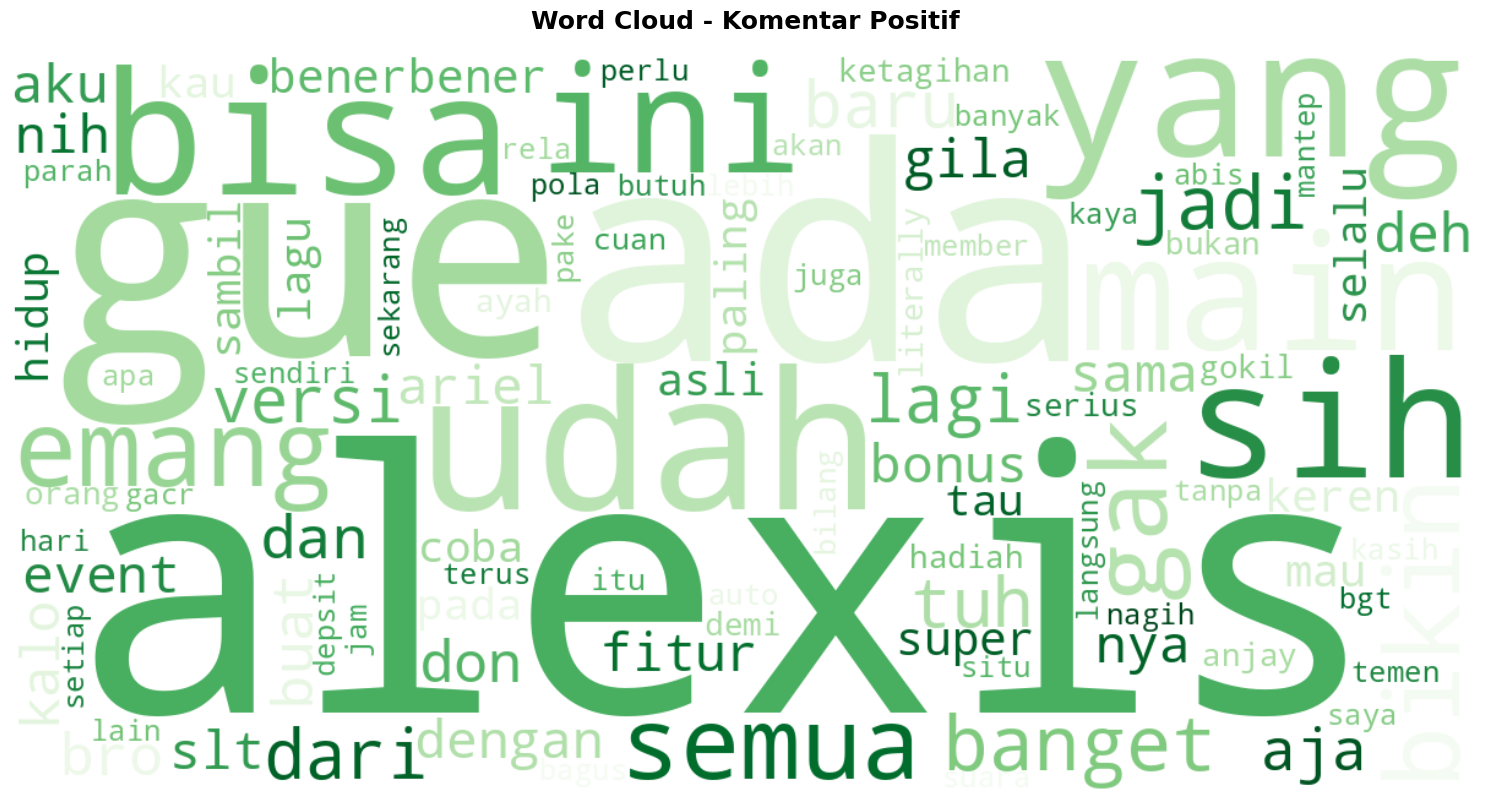

In [141]:
# Cell 8: Generate Word Cloud
def generate_wordcloud_safe(sentiment_value, title):
    """Generate word cloud untuk sentimen tertentu"""
    comments = df[df['Sentiment'] == sentiment_value]['Clean_Comment']
    comments = comments.fillna('').astype(str)

    text = ' '.join(comments)

    if not text.strip():
        print(f"Tidak ada komentar untuk sentimen {sentiment_value}")
        return

    try:
        # Konfigurasi warna berdasarkan sentimen
        colormap_dict = {0: 'Reds', 1: 'Blues', 2: 'Greens'}

        wordcloud = WordCloud(
            width=1200,
            height=600,
            background_color='white',
            collocations=False,
            max_words=100,
            colormap=colormap_dict.get(sentiment_value, 'viridis'),
            relative_scaling=0.5,
            min_word_length=3
        ).generate(text)

        plt.figure(figsize=(15, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - Komentar {title}', fontsize=18, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating wordcloud for {title}: {e}")

# Generate word clouds untuk setiap sentimen
sentiment_mapping = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

for sentiment_val, sentiment_name in sentiment_mapping.items():
    if sentiment_val in df['Sentiment'].unique():
        print(f"\n🎨 Generating Word Cloud untuk {sentiment_name}...")
        generate_wordcloud_safe(sentiment_val, sentiment_name)

In [142]:
# Cell 9: Persiapan Data untuk Machine Learning
# Persiapan data
X = df['Clean_Comment'].fillna('').astype(str)
y = df['Sentiment']

print("📊 Persiapan Data Machine Learning")
print("="*40)
print(f"Total sampel: {len(X)}")
print(f"Distribusi target:")
for i, count in y.value_counts().sort_index().items():
    sentiment_name = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}[i]
    print(f"  {sentiment_name}: {count} ({count/len(y)*100:.1f}%)")

# Split data dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n📈 Data Split:")
print(f"Training set: {len(X_train)} sampel")
print(f"Testing set: {len(X_test)} sampel")

# Cek distribusi di training dan testing set
print(f"\n📊 Distribusi Training Set:")
for i, count in y_train.value_counts().sort_index().items():
    sentiment_name = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}[i]
    print(f"  {sentiment_name}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\n📊 Distribusi Testing Set:")
for i, count in y_test.value_counts().sort_index().items():
    sentiment_name = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}[i]
    print(f"  {sentiment_name}: {count} ({count/len(y_test)*100:.1f}%)")

📊 Persiapan Data Machine Learning
Total sampel: 5582
Distribusi target:
  Negatif: 385 (6.9%)
  Netral: 1173 (21.0%)
  Positif: 4024 (72.1%)

📈 Data Split:
Training set: 4465 sampel
Testing set: 1117 sampel

📊 Distribusi Training Set:
  Negatif: 308 (6.9%)
  Netral: 938 (21.0%)
  Positif: 3219 (72.1%)

📊 Distribusi Testing Set:
  Negatif: 77 (6.9%)
  Netral: 235 (21.0%)
  Positif: 805 (72.1%)


In [143]:
# Cell 10: TF-IDF Vectorization
# TF-IDF Vectorization dengan parameter yang disesuaikan
print("🔄 Proses TF-IDF Vectorization...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    lowercase=True,
    ngram_range=(1, 2),        # Unigram dan bigram
    min_df=2,                  # Minimal muncul di 2 dokumen
    max_df=0.8,                # Maksimal muncul di 80% dokumen
    sublinear_tf=True,         # Gunakan scaling sublinear
    strip_accents='unicode'    # Hapus accent
)

# Fit dan transform data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"✅ TF-IDF Vectorization selesai!")
print(f"📊 Dimensi data training: {X_train_tfidf.shape}")
print(f"📊 Dimensi data testing: {X_test_tfidf.shape}")
print(f"📚 Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Lihat beberapa feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"🔤 Contoh features: {list(feature_names[:10])}")
print(f"🔤 Features terakhir: {list(feature_names[-10:])}")

🔄 Proses TF-IDF Vectorization...
✅ TF-IDF Vectorization selesai!
📊 Dimensi data training: (4465, 5000)
📊 Dimensi data testing: (1117, 5000)
📚 Vocabulary size: 5000
🔤 Contoh features: ['aa', 'aa ariel', 'aaaaa', 'aahh', 'aamiin', 'abal', 'abal abal', 'abal dahgua', 'abang', 'abang luar']
🔤 Features terakhir: ['yuk', 'yuk bisa', 'yukk', 'zaman', 'zanzibar', 'zeptodetik', 'zetta', 'zetta ultra', 'zeus', 'zonk']


In [144]:
# Cell 11: Training Model
print("🤖 Training Naive Bayes Model...")

# Inisialisasi dan training model
nb_classifier = MultinomialNB(alpha=0.1)  # Smoothing parameter
nb_classifier.fit(X_train_tfidf, y_train)

print("✅ Model training selesai!")

# Evaluasi pada training set
train_pred = nb_classifier.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, train_pred)
print(f"📈 Training Accuracy: {train_accuracy:.4f}")

# Prediksi pada testing set
y_pred = nb_classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"📊 Testing Accuracy: {test_accuracy:.4f}")

# Cek overfitting
if train_accuracy - test_accuracy > 0.1:
    print("⚠️  Kemungkinan terjadi overfitting!")
else:
    print("✅ Model tampak stabil!")

🤖 Training Naive Bayes Model...
✅ Model training selesai!
📈 Training Accuracy: 0.8526
📊 Testing Accuracy: 0.7574
✅ Model tampak stabil!


In [145]:
# Cell 12: Evaluasi Model Detail
print("📊 EVALUASI MODEL DETAIL")
print("="*50)

# Classification Report
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['Negatif', 'Netral', 'Positif'],
                          digits=4))

# Menghitung metrik per kelas
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
class_names = ['Negatif', 'Netral', 'Positif']

print("\n📊 Metrik Detail per Kelas:")
for i, class_name in enumerate(class_names):
    if i < len(precision):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
        print(f"  Support: {support[i]}")
        print()

# Overall metrics
print(f"🎯 Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"📊 Macro Average F1: {np.mean(f1):.4f}")
print(f"📊 Weighted Average F1: {np.average(f1, weights=support):.4f}")

📊 EVALUASI MODEL DETAIL

📈 Classification Report:
              precision    recall  f1-score   support

     Negatif     0.5714    0.3636    0.4444        77
      Netral     0.5475    0.5149    0.5307       235
     Positif     0.8229    0.8658    0.8438       805

    accuracy                         0.7574      1117
   macro avg     0.6473    0.5815    0.6063      1117
weighted avg     0.7476    0.7574    0.7504      1117


📊 Metrik Detail per Kelas:
Negatif:
  Precision: 0.5714
  Recall: 0.3636
  F1-Score: 0.4444
  Support: 77

Netral:
  Precision: 0.5475
  Recall: 0.5149
  F1-Score: 0.5307
  Support: 235

Positif:
  Precision: 0.8229
  Recall: 0.8658
  F1-Score: 0.8438
  Support: 805

🎯 Overall Accuracy: 0.7574
📊 Macro Average F1: 0.6063
📊 Weighted Average F1: 0.7504


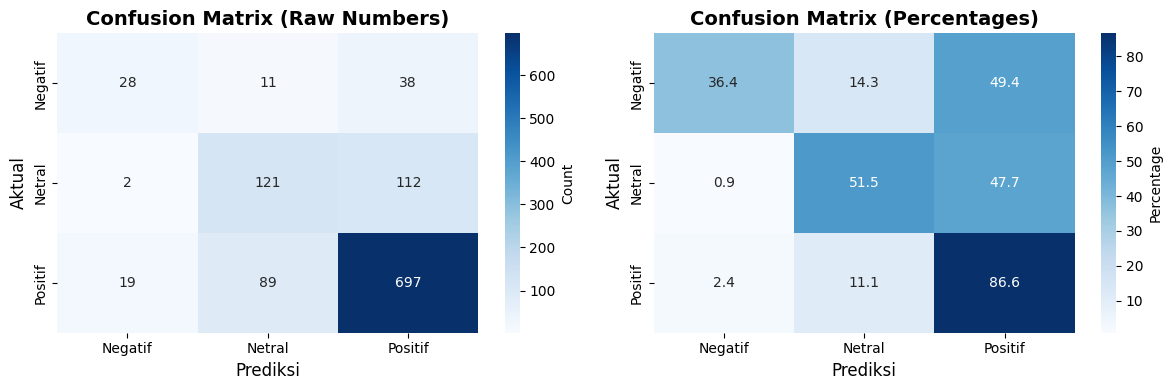


🔍 Analisis Kesalahan Klasifikasi:
  Negatif diprediksi sebagai Netral: 11 kasus (14.3%)
  Negatif diprediksi sebagai Positif: 38 kasus (49.4%)
  Netral diprediksi sebagai Negatif: 2 kasus (0.9%)
  Netral diprediksi sebagai Positif: 112 kasus (47.7%)
  Positif diprediksi sebagai Negatif: 19 kasus (2.4%)
  Positif diprediksi sebagai Netral: 89 kasus (11.1%)


In [146]:
# Cell 13: Confusion Matrix Visualization
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 4))

# Confusion Matrix Raw Numbers
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.title('Confusion Matrix (Raw Numbers)', fontsize=14, fontweight='bold')

# Confusion Matrix Percentages
plt.subplot(1, 2, 2)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'],
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Analisis kesalahan klasifikasi
print("\n🔍 Analisis Kesalahan Klasifikasi:")
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 0:
            print(f"  {class_names[i]} diprediksi sebagai {class_names[j]}: {cm[i][j]} kasus ({cm_percent[i][j]:.1f}%)")

In [147]:
# Cell 14: Fungsi Prediksi yang Ditingkatkan
def predict_sentiment_enhanced(text):
    """Fungsi prediksi sentimen yang ditingkatkan dengan deteksi kata kunci"""
    if not text or pd.isna(text):
        return {
            'text': text,
            'sentimen': 'Netral',
            'confidence': 0,
            'detail': {'Negatif': 0, 'Netral': 100, 'Positif': 0},
            'badwords_detected': [],
            'positive_words_detected': []
        }

    # Bersihkan teks
    processed_text = clean_text(text)

    # Deteksi kata negatif dan positif
    words = processed_text.lower().split()
    badwords_found = [word for word in words if word in BADWORDS_INDONESIAN]
    positive_words_found = [word for word in words if word in POSITIVE_WORDS]

    # Prediksi menggunakan model
    text_tfidf = tfidf_vectorizer.transform([processed_text])
    prediction = nb_classifier.predict(text_tfidf)[0]
    proba = nb_classifier.predict_proba(text_tfidf)[0]

    # Override prediksi jika ada badwords yang jelas
    original_prediction = prediction
    if len(badwords_found) > 0 and len(badwords_found) > len(positive_words_found):
        prediction = 0  # Paksa jadi negatif
    elif len(positive_words_found) > 0 and len(positive_words_found) > len(badwords_found):
        if prediction == 0:  # Jika model prediksi negatif tapi ada kata positif dominan
            prediction = 2  # Ubah jadi positif

    labels = {0: "Negatif", 1: "Netral", 2: "Positif"}

    result = {
        'text': text,
        'processed_text': processed_text,
        'sentimen': labels[prediction],
        'original_prediction': labels[original_prediction],
        'prediction_overridden': prediction != original_prediction,
        'confidence': round(proba[prediction] * 100, 2),
        'detail': {
            'Negatif': round(proba[0] * 100, 2),
            'Netral': round(proba[1] * 100, 2),
            'Positif': round(proba[2] * 100, 2)
        },
        'badwords_detected': badwords_found,
        'positive_words_detected': positive_words_found,
        'sentiment_score': calculate_sentiment_score(processed_text)
    }

    return result

print("✅ Fungsi prediksi enhanced siap digunakan!")

✅ Fungsi prediksi enhanced siap digunakan!


In [148]:
# Cell 15: Testing Prediksi dengan Berbagai Contoh
print("🧪 TESTING PREDIKSI MODEL")
print("="*50)

# Test dengan berbagai contoh
test_examples = [
    "Video ini bagus banget, suka deh!",
    "Anjing, konten sampah!",
    "Biasa aja sih videonya",
    "Mantap sekali penjelasannya",
    "Goblok banget pembawa acaranya",
    "Keren abis videonya, love it!",
    "Jelek banget kualitasnya",
    "Amazing content, very helpful",
    "Boring and useless",
    "Luar biasa bagus penjelasannya"
]

for i, example in enumerate(test_examples, 1):
    print(f"\n{i}. Teks: '{example}'")
    result = predict_sentiment_enhanced(example)

    print(f"   Sentimen: {result['sentimen']} ({result['confidence']}%)")

    if result['prediction_overridden']:
        print(f"   ⚠️  Prediksi dioverride dari {result['original_prediction']}")

    if result['badwords_detected']:
        print(f"   🚫 Kata negatif: {result['badwords_detected']}")

    if result['positive_words_detected']:
        print(f"   ✨ Kata positif: {result['positive_words_detected']}")

    print(f"   📊 Detail: Negatif {result['detail']['Negatif']}% | "
          f"Netral {result['detail']['Netral']}% | "
          f"Positif {result['detail']['Positif']}%")


🧪 TESTING PREDIKSI MODEL

1. Teks: 'Video ini bagus banget, suka deh!'
   Sentimen: Netral (69.99%)
   ✨ Kata positif: ['bagus', 'suka']
   📊 Detail: Negatif 0.18% | Netral 69.99% | Positif 29.83%

2. Teks: 'Anjing, konten sampah!'
   Sentimen: Negatif (3.24%)
   ⚠️  Prediksi dioverride dari Positif
   🚫 Kata negatif: ['anjing', 'sampah']
   📊 Detail: Negatif 3.24% | Netral 5.3% | Positif 91.46%

3. Teks: 'Biasa aja sih videonya'
   Sentimen: Positif (72.15%)
   📊 Detail: Negatif 1.07% | Netral 26.78% | Positif 72.15%

4. Teks: 'Mantap sekali penjelasannya'
   Sentimen: Netral (68.8%)
   ✨ Kata positif: ['mantap']
   📊 Detail: Negatif 4.55% | Netral 68.8% | Positif 26.65%

5. Teks: 'Goblok banget pembawa acaranya'
   Sentimen: Negatif (0.97%)
   ⚠️  Prediksi dioverride dari Positif
   🚫 Kata negatif: ['goblok']
   📊 Detail: Negatif 0.97% | Netral 47.6% | Positif 51.43%

6. Teks: 'Keren abis videonya, love it!'
   Sentimen: Netral (49.7%)
   ✨ Kata positif: ['keren', 'love']
   📊 Detail

In [149]:
# Cell 16: Simpan Model
print("💾 MENYIMPAN MODEL")
print("="*30)

try:
    # Simpan model dan vectorizer
    joblib.dump(nb_classifier, 'sentiment_model_improved.pkl')
    joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_improved.pkl')

    # Simpan juga dictionary kata kunci
    keyword_dict = {
        'badwords': BADWORDS_INDONESIAN,
        'positive_words': POSITIVE_WORDS
    }
    joblib.dump(keyword_dict, 'keyword_dictionary.pkl')

    print("✅ Model berhasil disimpan:")
    print("   - sentiment_model_improved.pkl")
    print("   - tfidf_vectorizer_improved.pkl")
    print("   - keyword_dictionary.pkl")

    # Verifikasi ukuran file
    import os
    files = ['sentiment_model_improved.pkl', 'tfidf_vectorizer_improved.pkl', 'keyword_dictionary.pkl']
    for file in files:
        if os.path.exists(file):
            size = os.path.getsize(file) / 1024  # KB
            print(f"   - {file}: {size:.1f} KB")

except Exception as e:
    print(f"❌ Error menyimpan model: {e}")

💾 MENYIMPAN MODEL
✅ Model berhasil disimpan:
   - sentiment_model_improved.pkl
   - tfidf_vectorizer_improved.pkl
   - keyword_dictionary.pkl
   - sentiment_model_improved.pkl: 235.2 KB
   - tfidf_vectorizer_improved.pkl: 192.1 KB
   - keyword_dictionary.pkl: 1.0 KB


In [ ]:
# Cell 17: Gradio Interface Setup
def gradio_predict_enhanced(text):
    """Fungsi untuk interface Gradio"""
    result = predict_sentiment_enhanced(text)

    # Format output yang menarik
    output = f"""📊 HASIL ANALISIS SENTIMEN ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📝 Teks Input: "{result['text']}"
🔄 Teks Diproses: "{result['processed_text']}"

🎯 Prediksi Sentimen: {result['sentimen']}
📈 Tingkat Keyakinan: {result['confidence']}%"""

    if result['prediction_overridden']:
        output += f"\n⚠️  Prediksi Model Asli: {result['original_prediction']} (dioverride oleh kata kunci)"

    output += f"""
📊 Detail Probabilitas:
   • Negatif: {result['detail']['Negatif']}%
   • Netral: {result['detail']['Netral']}%
   • Positif: {result['detail']['Positif']}%

📈 Skor Sentimen: {result['sentiment_score']}"""

    if result['badwords_detected']:
        output += f"\n🚫 Kata Negatif Terdeteksi: {', '.join(result['badwords_detected'])}"

    if result['positive_words_detected']:
        output += f"\n✨ Kata Positif Terdeteksi: {', '.join(result['positive_words_detected'])}"

    return output

# Interface Gradio
import gradio as gr

def create_gradio_interface():
    """Membuat interface Gradio untuk analisis sentimen"""

    # Contoh teks untuk demo
    examples = [
        "Saya sangat senang dengan layanan ini!",
        "Produk ini jelek sekali, tidak recommend",
        "Biasa saja, tidak ada yang istimewa",
        "Wah mantap banget ini aplikasinya!",
        "Benci banget sama sistem yang ribet ini"
    ]

    interface = gr.Interface(
        fn=gradio_predict_enhanced,
        inputs=gr.Textbox(
            label="Masukkan teks untuk analisis sentimen",
            placeholder="Ketik kalimat atau review yang ingin dianalisis...",
            lines=3
        ),
        outputs=gr.Textbox(
            label="Hasil Analisis",
            lines=15
        ),
        title="🎯 Analisis Sentimen Bahasa Indonesia",
        description="Masukkan teks dalam bahasa Indonesia untuk mengetahui sentimen (Positif, Negatif, atau Netral)",
        examples=examples,
        theme=gr.themes.Soft(),
        css="""
        .gradio-container {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        }
        .output-text {
            font-family: 'Courier New', monospace;
            background-color: #f8f9fa;
        }
        """
    )

    return interface

# Jalankan interface
def launch_gradio_safe():
    """Meluncurkan Gradio dengan handling port yang aman"""
    demo = create_gradio_interface()

    # Coba beberapa port jika yang pertama tidak tersedia
    ports_to_try = [7860, 7861, 7862, 7863, 7864]

    for port in ports_to_try:
        try:
            demo.launch(
                share=True,
                debug=True,
                server_port=port,
                quiet=False
            )
            print(f"✅ Gradio berhasil diluncurkan di port {port}")
            break
        except OSError as e:
            print(f"❌ Port {port} tidak tersedia, mencoba port berikutnya...")
            if port == ports_to_try[-1]:  # Jika port terakhir
                print("🔄 Menggunakan port otomatis...")
                demo.launch(share=True, debug=True)
                break

if __name__ == "__main__":
    launch_gradio_safe()

❌ Port 7860 tidak tersedia, mencoba port berikutnya...
❌ Port 7861 tidak tersedia, mencoba port berikutnya...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://324021e4cf57c55c3a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
